In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
print(tf.__version__)
print(scipy.__version__)

# Any results you write to the current directory are saved as output.

['googleplaystore_user_reviews.csv', 'license.txt', 'googleplaystore.csv']
1.13.1
1.1.0


In [2]:
!head ../input/license.txt
df = pd.read_csv('../input/googleplaystore.csv')
df[:5]

This work is licensed under the Creative Commons Attribution 3.0 Unported License. To view a copy of this license, visit http://creativecommons.org/licenses/by/3.0/.

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [3]:
# THOUGHTS
# 1. Unnecessary columns must be dropped (but lets do this after finishing 2 to 7)
# 2. Lets look at how many apps by category
# 3. Lets look at Size by Category
# 4. Lets look at Size by Rating
# 5. Lets look at Reviews by Category
# 6. Lets look at Rating by Price
# 7. Lets look at Rating by Content Rating
# 8. Lets look at Rating by Reviews
# 9. Lets drop Last Updated for now because it introduces a time dimensionality that we can't deal with now
# 10. Current Ver and Android Ver are irrelevant in our current scheme of things

# 11. Look at the data types of the remaining columns we are going to be working with. Don't feed non float tensors to our model

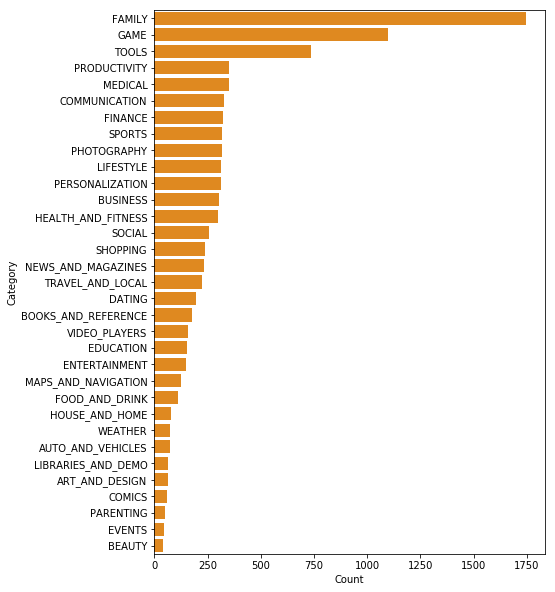

In [4]:
df.groupby('Category').count()

# There is a Category = '1.9'. Lets drop it
df = df[df['Category'] != '1.9']

# Extract Category and Count
CountCategory = df.groupby('Category').count()['Rating']
dfCountCategory = pd.DataFrame()
dfCountCategory['Category'] = CountCategory.index
dfCountCategory['Count'] = CountCategory.values
dfCountCategory.sort_values(inplace = True, by = ['Count'], ascending = False)

f, ax = plt.subplots(figsize = (7, 10))
sns.barplot(y = 'Category', x = 'Count', data = dfCountCategory, color = '#ff8c00')

> So, FAMILY, GAME and TOOLS categories have the highest number of Apps in the PlayStore.

In [5]:
# A function to convert our non-Int 'Size' column to Int
def getIntValues(nonInt):
    lst = []
    for s in nonInt:
        # Regex to match 1.2M, 12M, 120M, 1.2G, 12G, 12000G etc.
        string = re.search('([0-9]*[.]*[0-9]+)([a-z]|[A-Z])', s)

        # If there is a match
        if string != None:
            # For Gigabytes
            if (string.group(2) == 'G') | (string.group(2) == 'g'):
                num = float(string.group(1)) * 1024 * 1024 * 1024
            # For Megabytes
            elif (string.group(2) == 'M') | (string.group(2) == 'm'):
                num = float(string.group(1)) * 1024 * 1024
            # For Kilobytes
            elif (string.group(2) == 'K') | (string.group(2) == 'k'):
                num = float(string.group(1)) * 1024
            else:
                num = 0

            num = int(num)
        # If there is no match
        else:
            num = 0

        # Create a list of integer converted values
        lst.append(num)
    return lst

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text xticklabel objects>)

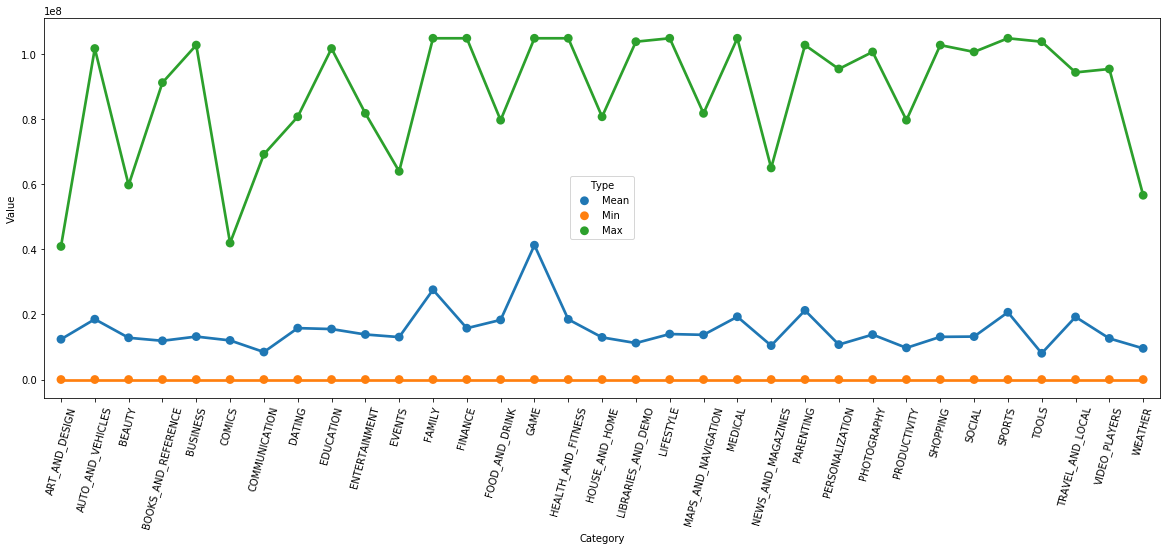

In [6]:
# Lets create a sub DataFrame for our Size vs Category comparison
dfCategoryBySize = pd.DataFrame()
dfCategoryBySize['Category'] = df['Category']
dfCategoryBySize['Size'] = df['Size']

# We have to change the 'Size' column to integer for a proper comparison
lstSize = getIntValues(dfCategoryBySize['Size'])
    
# Create an array to be included in the original DF
arrSize = np.array(lstSize)
dfCategoryBySize.drop('Size', inplace = True, axis = 1)
dfCategoryBySize['Size'] = arrSize

# Now, get some statistics
descCategoryBySize = dfCategoryBySize.groupby('Category').describe()

# Creation of final DF for comparison
i = 0
lstCategory = []
lstValue = []
lstType = []
# Doing this so that we can get hue = ['Mean', 'Min', 'Max']
for i in range(len(descCategoryBySize)):
    lower = i * 3
    upper = i * 3 + 3
    for j in range(lower, upper):
        lstCategory.append(descCategoryBySize.iloc[i].name)
        
    lstValue.append(int(descCategoryBySize.iloc[i]['Size']['mean']))
    lstValue.append(int(descCategoryBySize.iloc[i]['Size']['min']))
    lstValue.append(int(descCategoryBySize.iloc[i]['Size']['max']))
    lstType.append('Mean')
    lstType.append('Min')
    lstType.append('Max')
    
    i = i + 1
    
arrCategory = np.array(lstCategory)
arrValue = np.array(lstValue)
arrType = np.array(lstType)

# Final DF ready
CategoryBySize = pd.DataFrame()
CategoryBySize['Category'] = arrCategory
CategoryBySize['Value'] = arrValue
CategoryBySize['Type'] = arrType

# Set figure size
f, ax = plt.subplots(figsize = (20, 7))
g = sns.pointplot(data = CategoryBySize, x = 'Category', y = 'Value', hue = 'Type')
# Rotate x-label so that they are legible
plt.xticks(rotation = 75)

1. GAME has the highest Mean size of apps
2. Followed by FAMILY
3. Suprisingly, even though TOOLS has the 3rd highest number of Apps in the PlayStore, its Mean size is quite low

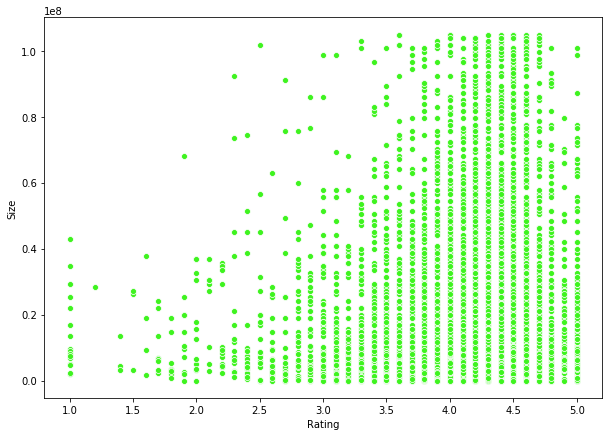

In [7]:
# Sub DataFrame to do our Rating vs Size comparison
dfRatingVsSize = pd.DataFrame()
dfRatingVsSize['Rating'] = df['Rating']
dfRatingVsSize['Size'] = df['Size']

# Get Int values for 'Size'
lstSize = getIntValues(dfRatingVsSize['Size'])
arrSize = np.array(lstSize)
dfRatingVsSize.drop('Size', axis = 1, inplace = True)
dfRatingVsSize['Size'] = arrSize

# Drop null 'Rating' values
dfRatingVsSize.dropna(how = 'any', inplace = True)

f, ax = plt.subplots(figsize = (10, 7))
sns.scatterplot(data = dfRatingVsSize, y = 'Size', x = 'Rating', color = '#3ff320')

1. Size does not seem to matter for rating of apps. There is no sharp decline in ratings as size increases.
2. There are more Data points below 60 MB, than above it

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


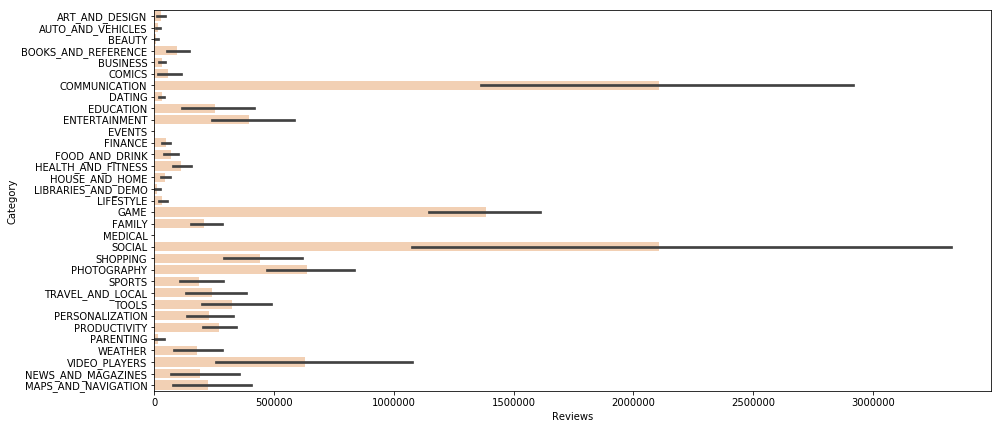

In [8]:
dfReviewsByCategory = pd.DataFrame()
dfReviewsByCategory['Reviews'] = df['Reviews']
dfReviewsByCategory['Category'] = df['Category']

dfReviewsByCategory['Reviews'] = dfReviewsByCategory['Reviews'].astype(int)

f, ax = plt.subplots(figsize = (15, 7))
sns.barplot(data = dfReviewsByCategory, y = 'Category', x = 'Reviews', color = '#fccfaa')

1. High Reviews for SOCIAL, GAME and COMMUNICATION categories
2. FAMILY and TOOLS which figured in the hightest number of apps, haven't really gotten many reviews overall

In [9]:
# Function to remove Dollar sign from Price column
def getDollarValue(nonInt):
    lst = []
    for s in nonInt:
        # Regex to match $4.99, $44.999, $444.999, $0, 0
        string = re.search('([$])*([0-9]*[.]*[0-9]+)', s)

        # If there is a match
        if string != None:
            num = string.group(2)
            num = float(num)
        # If there is no match
        else:
            num = 0

        # Create a list of number converted values
        lst.append(num)
    return lst

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


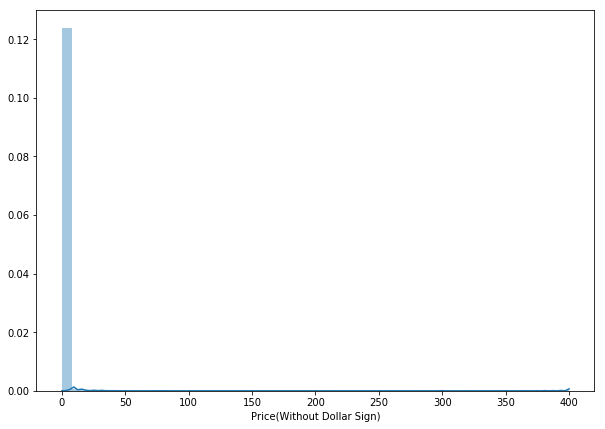

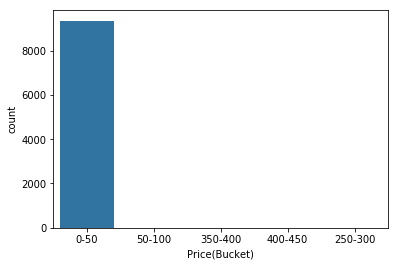

In [10]:
# Sub DF for our comparison
dfRatingByPrice = pd.DataFrame()
dfRatingByPrice['Rating'] = df['Rating']
dfRatingByPrice['Price'] = df['Price']

# Drop null values
dfRatingByPrice.dropna(how = 'any', inplace = True)

# Create a column in our DF which does not have the Dollar Sign in it
lstPrice = getDollarValue(dfRatingByPrice['Price'])
arrPrice = np.array(lstPrice)
dfRatingByPrice['Price(Without Dollar Sign)'] = arrPrice

# Got over enthusiastic and created buckets myself
priceBinsBoundary = []
minPrice = dfRatingByPrice['Price(Without Dollar Sign)'].min().astype(int)
maxPrice = dfRatingByPrice['Price(Without Dollar Sign)'].max().astype(int)
Step = 50

for r in range(minPrice, maxPrice + Step + 1, Step):
    priceBinsBoundary.append(r)
    
arrPriceBinsBoundary = np.array(priceBinsBoundary)
arrPrice = dfRatingByPrice['Price(Without Dollar Sign)'].values
arrPriceBins = np.digitize(arrPrice, arrPriceBinsBoundary)

lstPriceBinsStr = []
for i in range(len(arrPriceBins)):
    binsStr = str(arrPriceBinsBoundary[arrPriceBins[i] - 1]) + '-' + str(arrPriceBinsBoundary[arrPriceBins[i]])
    lstPriceBinsStr.append(binsStr)
    
arrPriceBinsStr = np.array(lstPriceBinsStr)
dfRatingByPrice['Price(Bucket)'] = arrPriceBinsStr

f, ax1 = plt.subplots(figsize = (10, 7))
sns.distplot(dfRatingByPrice['Price(Without Dollar Sign)'])
plt.show()
sns.countplot(data = dfRatingByPrice, x = 'Price(Bucket)')
plt.show()

Considering the distribution of Price, it would not be correct to evaluate Rating based on Price.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


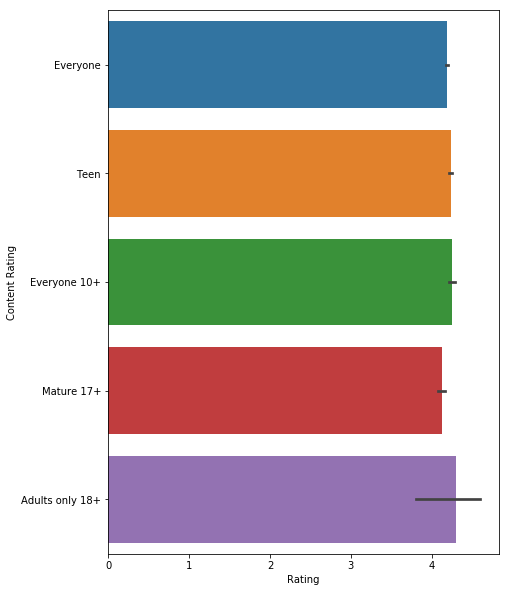

In [11]:
dfRatingByCRating = pd.DataFrame()
dfRatingByCRating['Rating'] = df['Rating']
dfRatingByCRating['Content Rating'] = df['Content Rating']

dfRatingByCRating = dfRatingByCRating[dfRatingByCRating['Content Rating'] != 'Unrated']

f, ax = plt.subplots(figsize = (7, 10))
sns.barplot(data = dfRatingByCRating, x = 'Rating', y = 'Content Rating')

So, looks like Rating is almost consistent across different Content Ratings

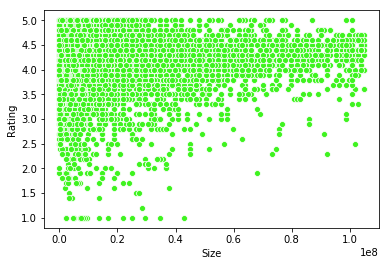

In [12]:
dfRatingByReviews = pd.DataFrame()
dfRatingByReviews['Rating'] = df['Rating']
dfRatingByReviews['Reviews'] = df['Reviews']

dfRatingByReviews.dropna(how = 'any', inplace = True)

sns.scatterplot(data = dfRatingVsSize, x = 'Size', y = 'Rating', color = '#3ff320')

1. Reviews cannot really give us an idea about Ratings when the number of reviews is less
2. However, when the number of Reviews is high, the Ratings are consistently high
3. But it also looks like if there are Reviews on an app, the probability of high Ratings is greater than probability of low Ratings. This aspect needs to be looked into further

    a. The number of data points at greater than 0 reviews needs to be compared with the number of data points at reviews = 0

2169
7197


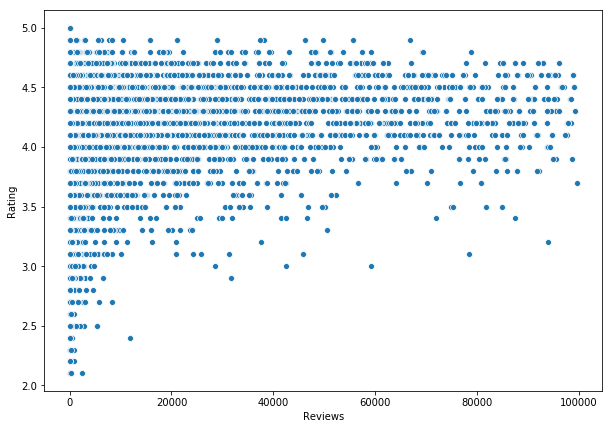

In [13]:
dfRatingByReviews = pd.DataFrame()
dfRatingByReviews['Rating'] = df['Rating']
dfRatingByReviews['Reviews'] = df['Reviews']

dfRatingByReviews.dropna(how = 'any', inplace = True)
dfRatingByReviews = dfRatingByReviews[dfRatingByReviews['Reviews'] != '3.0M']
dfRatingByReviews['Reviews'] = dfRatingByReviews['Reviews'].astype(int)

print(dfRatingByReviews[dfRatingByReviews['Reviews'] >  100000]['Reviews'].count())
print(dfRatingByReviews[dfRatingByReviews['Reviews'] <= 100000]['Reviews'].count())

dfRatingByReviewsZoom = pd.DataFrame()
dfRatingByReviewsZoom = dfRatingByReviews[(dfRatingByReviews['Reviews'] <= 100000) & \
                                         (dfRatingByReviews['Rating'] > 2)]

f, ax = plt.subplots(figsize = (10, 7))
sns.scatterplot(data = dfRatingByReviewsZoom, x = 'Reviews', y = 'Rating')

So, hopefully Reviews can be a good feature.

In [14]:
# Lets train a model just by relying on Reviews
dfStage = pd.DataFrame()
dfStage['Rating'] = df['Rating']
dfStage['Reviews'] = dfRatingByReviews['Reviews']
dfStage.dropna(how = 'any', inplace = True)

# Lets split the dataset
splitThreshold = int(len(dfStage) * .80)
dfTrain = dfStage[0: splitThreshold]
dfTest = dfStage[splitThreshold + 1: len(dfStage)]

In [15]:
# Create Train and Test Input Functions
TrainInputFunction = tf.estimator.inputs.pandas_input_fn(
    x = dfTrain,
    y = dfTrain['Rating'],
    batch_size = 128,
    num_epochs = 200,
    shuffle = True,
    queue_capacity = 1000,
    num_threads = 1,
)

TestInputFunction = tf.estimator.inputs.pandas_input_fn(
    x = dfTest,
    y = None,
    batch_size = 128,
    shuffle = False,
    num_threads = 1
)

RatingT = tf.feature_column.numeric_column('Rating')
ReviewsT = tf.feature_column.numeric_column('Reviews')

In [16]:
# Lets train a DNN
OUTDIR = 'Trained-DNN'
shutil.rmtree(OUTDIR, ignore_errors = True)

model = tf.estimator.DNNRegressor(
    feature_columns = [RatingT, ReviewsT],
    model_dir = OUTDIR,
    hidden_units=[32, 16]
)

model.train(input_fn=TrainInputFunction)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'Trained-DNN', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd119fbe780>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
To construct input pipelines, use the `tf.data`

In [17]:
predictions = model.predict(input_fn=TestInputFunction)
lstPredictions = []
for f in predictions:
    lstPredictions.append(f['predictions'][0])
    
lstPredictions
arrPredictions = np.array(lstPredictions)
print(arrPredictions)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from Trained-DNN/model.ckpt-11707
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[161.49675   129.76213    86.91985   ...   4.9680715   4.5626874
 104.105034 ]


In [18]:
dfTest['Actual Prediction'] = arrPredictions
dfTest[:5]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Rating,Reviews,Actual Prediction
8457,4.5,617732.0,161.496750
8458,4.3,496397.0,129.762131
8459,4.8,332623.0,86.919853
8460,4.5,371318.0,97.045219
8461,4.6,216513.0,56.554371


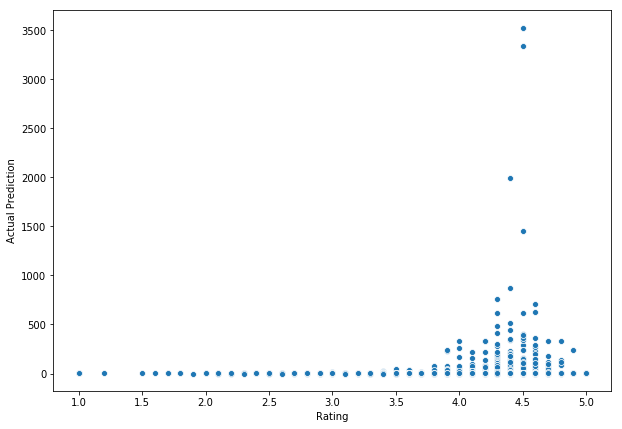

In [19]:
f, ax = plt.subplots(figsize = (10, 7))
sns.scatterplot(data = dfTest, x = 'Rating', y = 'Actual Prediction')

So, here's the final predictions. Not a good graph to look at at all. Not many predictions are accurate.